In [1]:
import sys

import seaborn
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds, open_f
from core.make_answer import make_ans_file 
from core.ensembles import get_bagging_pred, print_bagging_ensemble_statistic, print_models_statistic, get_ensemble_modelbase, get_modeset, get_raw_bagging_pred


C:\Users\Salam\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

In [3]:
acc_test_ds = open_f("smote_data_train_5000", back=2)

In [4]:
acc_test_ds_y = acc_test_ds["labels"]
acc_test_ds_x = acc_test_ds["images"] / 255.

In [5]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=2)
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.argmax(val_ds_y, axis=1)

In [6]:
model_1 = tf.keras.models.load_model(f'../checkpoints/model_g_1_categorical_accuracy.h5')
model_3 = tf.keras.models.load_model(f'../checkpoints/model_g_3_categorical_accuracy.h5')
model_smote = tf.keras.models.load_model(f'../checkpoints/model_s_smote_categorical_accuracy.h5')
model_c = tf.keras.models.load_model(f'../checkpoints/model_C_EN_1_categorical_accuracy.h5')
model_8 = tf.keras.models.load_model(f'../checkpoints/model_g_8_categorical_accuracy.h5')
model_36h_griganet = tf.keras.models.load_model(f'../checkpoints/model_g_11_categorical_accuracy.h5')
model_16 = tf.keras.models.load_model(f'../checkpoints/model_g_16_avg_categorical_accuracy.h5')
model_17 = tf.keras.models.load_model(f'../checkpoints/model_g_17_avg_categorical_accuracy.h5')

In [7]:
ova_0 = tf.keras.models.load_model(f'../checkpoints/model_zero_categorical_accuracy.h5')
ova_1 = tf.keras.models.load_model(f'../checkpoints/model_one_categorical_accuracy.h5')
ova_2 = tf.keras.models.load_model(f'../checkpoints/model_two_categorical_accuracy.h5')
ova_3 = tf.keras.models.load_model(f'../checkpoints/model_three_categorical_accuracy.h5')
ova_4 = tf.keras.models.load_model(f'../checkpoints/model_four_categorical_accuracy.h5')
ova_5 = tf.keras.models.load_model(f'../checkpoints/model_five_categorical_accuracy.h5')
ova_6 = tf.keras.models.load_model(f'../checkpoints/model_six_categorical_accuracy.h5')
ova_7 = tf.keras.models.load_model(f'../checkpoints/model_seven_categorical_accuracy.h5')
ova_8 = tf.keras.models.load_model(f'../checkpoints/model_eight_categorical_accuracy.h5')
ova_9 = tf.keras.models.load_model(f'../checkpoints/model_nine_categorical_accuracy.h5')

ova = {0:ova_0, 1:ova_1, 2:ova_2, 3:ova_3, 4:ova_4, 5:ova_5,  6:ova_6, 7:ova_7, 8:ova_8, 9:ova_9}

In [8]:
models = [model_1, model_smote, model_8, model_c, model_36h_griganet, model_16, model_17]
names = ["model G1", "model SMOTE", "model G8", "model C1", "model G11", "model G16", "model G17"]

modelbase = get_ensemble_modelbase(models=models, names=names, x_val=acc_test_ds_x)

1563/1563 [==============================] - 19s 12ms/step


In [12]:
print_models_statistic(modelbase=modelbase, y_val=acc_test_ds_y)

SCORE
model G1: accuracy: 0.97812 f1_score: 0.9781390642763794
model SMOTE: accuracy: 0.99148 f1_score: 0.9914831152938497
model G8: accuracy: 0.98592 f1_score: 0.9859201269079992
model C1: accuracy: 0.9719 f1_score: 0.9719381931043831
model G11: accuracy: 0.98904 f1_score: 0.9890429354052381
model G16: accuracy: 0.93674 f1_score: 0.9366979284539843
model G17: accuracy: 0.99096 f1_score: 0.9909604934305734


In [132]:
selected_names = ["model SMOTE", "model G8",  "model C1", "model G11", "model G17"]
modelset = get_modeset(modelbase, selected_names)

In [133]:
y_test_acc_pred = print_bagging_ensemble_statistic(modelset=modelset, y_val=acc_test_ds_y)

SCORE

ensemble accuracy: 0.99684

ensemble f1_score: 0.9968398213843036


In [23]:
ova_preds = {}
for i in range(10):
    ova_preds[i] = ova[i].predict(acc_test_ds_x, verbose=True)

1563/1563 [==============================] - 71s 45ms/step


In [93]:
def min_max_scaler(x):
    min_x = min(x)
    max_x = max(x)
    result = []
    for i in x:
        result.append((i - min_x)/(max_x-min_x))
    return np.array(result)

final_ova_preds = np.full((len(acc_test_ds_x), 10), 0.)
for i in range(len(acc_test_ds_y)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_preds[j][i]
    final_ova_preds[i] = min_max_scaler(l)

In [25]:
# Получить первый/второй/третий по страшинству предикт. (максимальные логиты).
def get_ordinal_pred(y_logits, i):
    work = list(y_logits.copy())
    work.sort(reverse=True)
    return list(y_logits).index(work[i])
    

In [64]:
# ALPHA HYBRID TEST
raw_pred = np.full((len(acc_test_ds_x), 10), 0.)
for model in modelset:
    raw_pred += model[1]

# raw_pred = get_raw_bagging_pred(modelset=modelset, x_val=acc_test_ds_x)

changes_count = 0
undo_count = 0
cooked_pred = []
for i in range(len(raw_pred)):
    # if i % 100 == 0:
    #     print(f"progress: {i}/{len(raw_pred)} changes {changes_count}")
    raw_y = raw_pred[i]
    raw_x = np.expand_dims(acc_test_ds_x[i], 0)
    first_y_pred = get_ordinal_pred(raw_y, 0)
    if ova_preds[first_y_pred][i] >= 0:
        cooked_pred.append(first_y_pred)
        continue
    
    changes_count += 1
    
    second_y_pred = get_ordinal_pred(raw_y, 1)
    if ova_preds[second_y_pred][i] >= 0:
        cooked_pred.append(second_y_pred)
        continue

    third_y_pred = get_ordinal_pred(raw_y, 2)
    if ova_preds[third_y_pred][i] >= 0:
        cooked_pred.append(third_y_pred)
        continue

    changes_count-=1
    undo_count +=1
    cooked_pred.append(first_y_pred)
print(f"TOTAL: {changes_count} changes {undo_count} undo")
cooked_pred = np.array(cooked_pred)
print(np.sum(cooked_pred == acc_test_ds_y) / len(acc_test_ds_y))

TOTAL: 82 changes 148 undo
0.99776


In [67]:
from sklearn.preprocessing import MinMaxScaler

In [97]:
# BETA HYBRID TEST
raw_pred = np.full((len(acc_test_ds_x), 10), 0.)

for model in modelset:
    scaler = MinMaxScaler(feature_range = (-1,1))
    x_test = scaler.fit_transform(model[1])
    raw_pred += model[1]

# raw_pred = get_raw_bagging_pred(modelset=modelset, x_val=acc_test_ds_x)

changes_count = 0
undo_count = 0
cooked_pred = []
for i in range(len(raw_pred)):
    raw_y = raw_pred[i]
    raw_x = np.expand_dims(acc_test_ds_x[i], 0)
    w = final_ova_preds[i] * raw_pred[i]
    cooked_pred.append(np.argmax(w))

print(f"TOTAL: {changes_count} changes {undo_count} undo")
cooked_pred = np.array(cooked_pred)
print(np.sum(cooked_pred == acc_test_ds_y) / len(acc_test_ds_y))

TOTAL: 0 changes 0 undo
0.9976


In [78]:
for i in range(len(acc_test_ds_y)):
    if (acc_test_ds_y[i] == 1) and (acc_test_ds_y[i] != cooked_pred[i]):
        raw_x = np.expand_dims(acc_test_ds_x[i], 0)
        print("true", acc_test_ds_y[i], "pred", cooked_pred[i])
        print(raw_pred[i])
        print(get_ordinal_pred(raw_pred[i], 0), get_ordinal_pred(raw_pred[i], 1), get_ordinal_pred(raw_pred[i], 2))
        print(ova[get_ordinal_pred(raw_pred[i], 0)].predict(raw_x, verbose=False))
        print(ova[get_ordinal_pred(raw_pred[i], 1)].predict(raw_x, verbose=False))
        print(ova[get_ordinal_pred(raw_pred[i], 2)].predict(raw_x, verbose=False))

true 1 pred 6
[-13.28052855 -11.1449492  -34.13957214 -19.31501508 -30.64410543
 -12.63790345  38.8792522  -36.17322516 -21.10279655 -33.81371069]
6 1 5
[[2.7371573]]
[[6.3755946]]
[[-20.698814]]
true 1 pred 7
[-21.73170418   9.79713607  -7.78725839 -13.22533455  -7.29139507
 -16.35444856 -20.83102989  30.89833891 -37.27329969 -18.78424275]
7 1 4
[[11.410912]]
[[5.6094546]]
[[-10.357969]]
true 1 pred 7
[-25.27520967  18.25315201  -0.25760555  -4.62628073  -6.541049
 -36.0251646  -21.33108348  23.77338982 -29.01505423 -35.15639114]
7 1 2
[[-3.2634404]]
[[4.75742]]
[[-7.2536526]]
true 1 pred 2
[-48.49897385  28.33808422  32.70008183  10.76848188  -6.20213461
 -37.86334109 -48.03590393 -27.66523308 -31.28304827 -17.37155628]
2 1 3
[[-1.1111035]]
[[4.5668764]]
[[-28.415735]]
true 1 pred 2
[-29.95615554  13.20127177  32.23777318 -14.42154789  -0.59984207
 -34.65856028 -43.79721689 -29.39878941 -38.25517702 -45.81045437]
2 1 4
[[7.418896]]
[[8.169953]]
[[-3.9028947]]
true 1 pred 4
[-48.54357

In [117]:
for i in range(len(acc_test_ds_y)):
    if acc_test_ds_y[i] != cooked_pred[i]:
        raw_x = np.expand_dims(acc_test_ds_x[i], 0)
        print("true", acc_test_ds_y[i], "pred", cooked_pred[i])
        print(raw_pred[i])
        print(get_ordinal_pred(raw_pred[i], 0), get_ordinal_pred(raw_pred[i], 1), get_ordinal_pred(raw_pred[i], 2))
        print(ova[get_ordinal_pred(raw_pred[i], 0)].predict(raw_x, verbose=False))
        print(ova[get_ordinal_pred(raw_pred[i], 1)].predict(raw_x, verbose=False))
        print(ova[get_ordinal_pred(raw_pred[i], 2)].predict(raw_x, verbose=False))

true 0 pred 5
[ -5.69206065 -23.32249045 -30.0251776   -4.90756691 -51.48598337
  41.32566237 -18.87600803 -36.34807807 -46.35612202 -14.72190535]
5 3 0
[[2.2958956]]
[[-20.751385]]
[[-1.2219781]]
true 0 pred 4
[  8.16666538  -6.53812099  -8.71734309 -13.58105564   8.80729379
 -23.46662259 -14.64471006 -22.44402528 -12.73642635 -24.01495862]
4 0 1
[[5.035124]]
[[4.910747]]
[[-19.464777]]
true 0 pred 1
[ 19.47349191  28.74007177 -24.91910887 -28.24604213 -25.91290212
 -32.41084802 -11.14535487  -6.06104898 -28.2226702  -20.19856483]
1 0 7
[[-9.002591]]
[[-1.3898554]]
[[-13.686717]]
true 1 pred 6
[-12.97140872  -7.07166457 -31.35802865 -19.7923339  -37.02088213
 -10.97832203  39.49989039 -38.20176959 -26.29812384 -32.45247078]
6 1 5
[[2.7371573]]
[[6.3755946]]
[[-20.698814]]
true 1 pred 7
[-23.95579571  13.2496171   -5.82030272 -12.18188742  -8.78597498
 -16.22539416 -20.95598499  36.29008114 -43.69424152 -18.87314372]
7 1 2
[[11.410912]]
[[5.6094546]]
[[-11.286983]]
true 1 pred 2
[-33.3

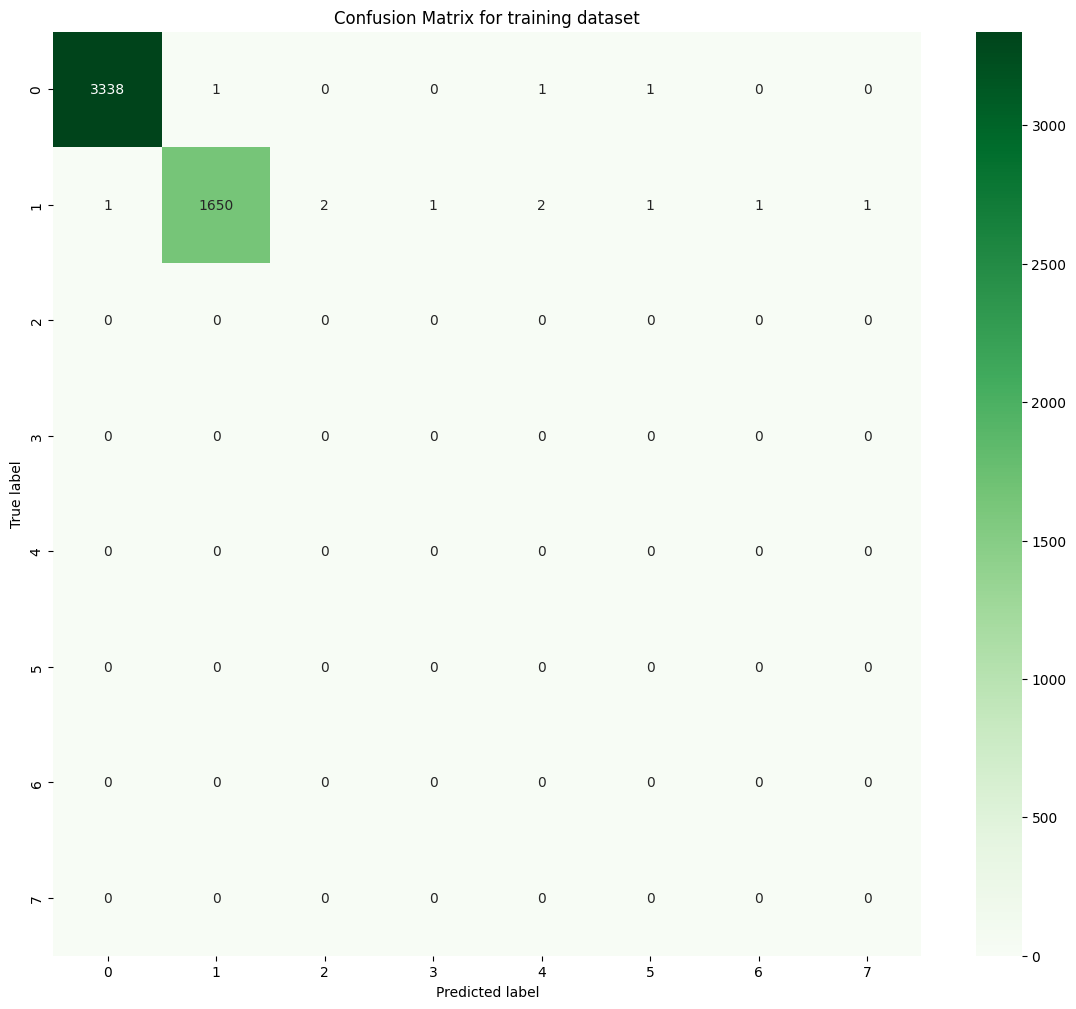

In [95]:
matrix = confusion_matrix(acc_test_ds_y, cooked_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

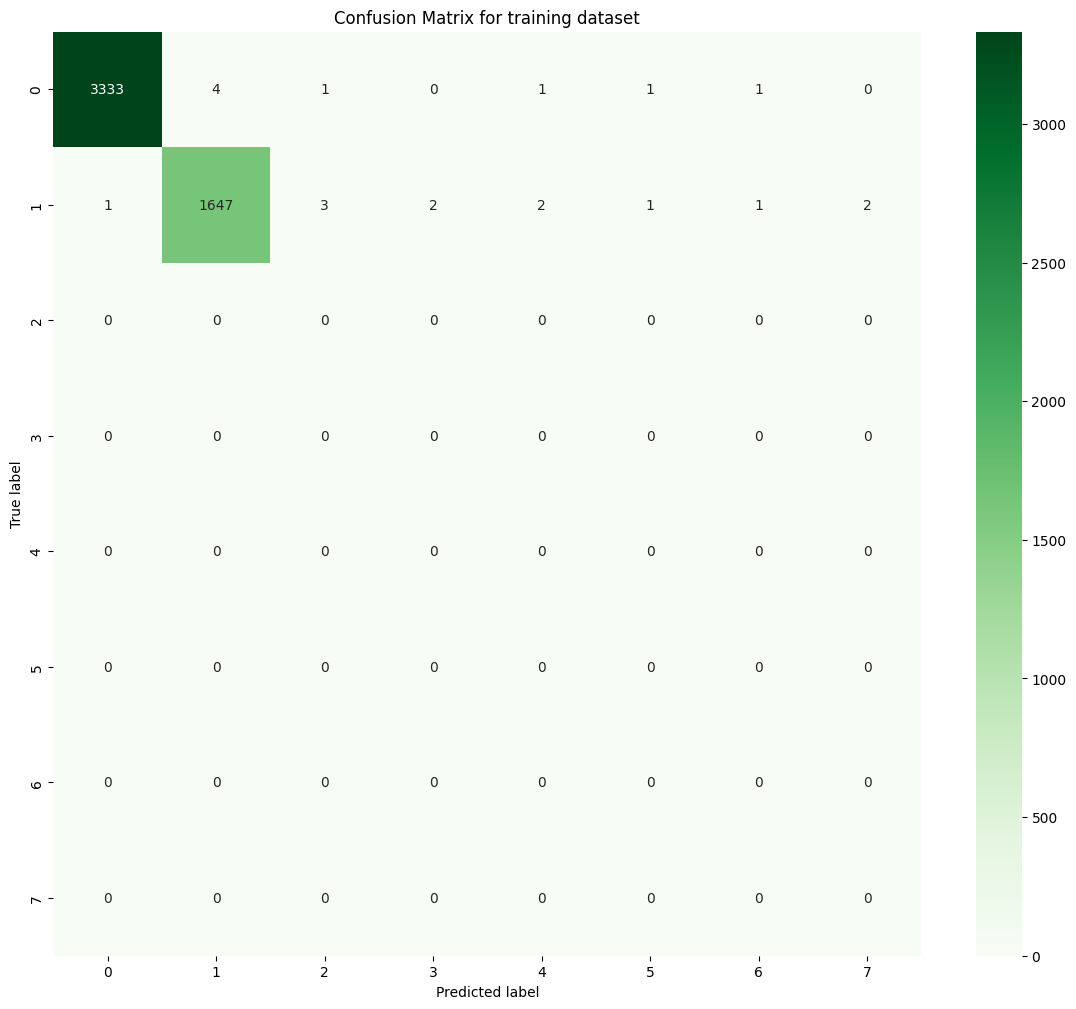

In [72]:
matrix = confusion_matrix(acc_test_ds_y, y_test_acc_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

делаем тестовый предикт и сохраняем:

In [135]:
raw_pred_test = get_raw_bagging_pred(modelset=modelset, x_val=test_ds)

782/782 [==============================] - 9s 11ms/step


In [136]:
ova_test_preds = {}
for i in range(10):
    ova_test_preds[i] = ova[i].predict(test_ds, verbose=True)

782/782 [==============================] - 35s 45ms/step


In [226]:
final_ova_test_preds = np.full((len(test_ds), 10), 0.)
for i in range(len(test_ds)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_test_preds[j][i]
    final_ova_test_preds[i] = min_max_scaler(l)

final_ova_test_preds_witout_scaler= np.full((len(test_ds), 10), 0.)
for i in range(len(test_ds)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_test_preds[j][i]
    final_ova_test_preds_witout_scaler[i] = l.copy()

In [138]:
# ALPHA HYBRID

changes_count = 0
undo_cound = 0
cooked_pred = []
for i in range(len(raw_pred_test)):
    raw_y = raw_pred_test[i]
    first_y_pred = get_ordinal_pred(raw_y, 0)
    if ova_test_preds[first_y_pred][i] >= 0:
        cooked_pred.append(first_y_pred)
        continue
    
    changes_count += 1
    
    second_y_pred = get_ordinal_pred(raw_y, 1)
    if ova_test_preds[second_y_pred][i] >= 0:
        cooked_pred.append(second_y_pred)
        continue

    third_y_pred = get_ordinal_pred(raw_y, 2)
    if ova_test_preds[third_y_pred][i] >= 0:
        cooked_pred.append(third_y_pred)
        continue

    changes_count -= 1
    undo_cound += 1
    cooked_pred.append(first_y_pred)

print(f"Total: {changes_count} changes; {undo_cound} undo")
wunderwafel_ensy_alphahybrid = np.array(cooked_pred)

Total: 354 changes; 713 undo


In [49]:
changes = []
for i in range(len(test_ds)):
    if np.argmax(raw_pred[i]) != wunderwafel_ensy_alphahybrid[i]:
        raw_x = np.expand_dims(test_ds[i], 0)
        print("potential true", np.argmax(raw_pred[i]), "changed", wunderwafel_ensy_alphahybrid[i])
        
        # print(raw_pred[i])
        # print(get_ordinal_pred(raw_pred[i], 0), get_ordinal_pred(raw_pred[i], 1), get_ordinal_pred(raw_pred[i], 2))
        # print(ova[get_ordinal_pred(raw_pred[i], 0)].predict(raw_x, verbose=False))
        # print(ova[get_ordinal_pred(raw_pred[i], 1)].predict(raw_x, verbose=False))
        # print(ova[get_ordinal_pred(raw_pred[i], 2)].predict(raw_x, verbose=False))

potential true 2 changed 7
potential true 8 changed 0
potential true 1 changed 0
potential true 9 changed 2
potential true 2 changed 9
potential true 3 changed 5
potential true 6 changed 5
potential true 3 changed 2
potential true 9 changed 4
potential true 3 changed 4
potential true 4 changed 2
potential true 6 changed 4
potential true 8 changed 4
potential true 6 changed 0
potential true 1 changed 5
potential true 4 changed 3
potential true 7 changed 3
potential true 6 changed 5
potential true 8 changed 0
potential true 1 changed 3
potential true 3 changed 5
potential true 6 changed 5
potential true 4 changed 7
potential true 2 changed 7
potential true 6 changed 5
potential true 3 changed 5
potential true 1 changed 4
potential true 6 changed 5
potential true 1 changed 4
potential true 1 changed 4
potential true 3 changed 7
potential true 4 changed 1
potential true 3 changed 8
potential true 0 changed 2
potential true 3 changed 2
potential true 1 changed 0
potential true 4 changed 1
p

In [227]:
# BETA HYBRID TEST
cooked_pred = []
nothing_changed = 0
skip = np.random.randint(0, 1000)
for i in range(len(raw_pred_test)):
    if np.argmax(raw_pred_test[i]) == np.argmax(final_ova_test_preds[i]):
        cooked_pred.append(np.argmax(raw_pred_test[i]))
        nothing_changed+=1
        continue
    # skip -= 1
    # if skip == 0:
    #     raw_x = np.expand_dims(test_ds[i], 0)
    #     print("\npotential true", np.argmax(raw_pred_test[i]), "changed", np.argmax(raw_pred_test[i] * final_ova_test_preds[i]))
    #     print("raw    \n", raw_pred_test[i])
    #     print("handled\n", raw_pred_test[i] * final_ova_test_preds[i])
    #     print("ova\n", final_ova_test_preds[i])
    #     plt.imshow(test_ds[i])
    #     break
    raw_y = raw_pred_test[i]
    w = final_ova_test_preds[i] * raw_y
    cooked_pred.append(np.argmax(w))




print(f"TOTAL {nothing_changed} not changed")
cooked_pred = np.array(cooked_pred)
print(np.sum(cooked_pred != np.array([np.argmax(k) for k in raw_pred_test])))
print(np.where(cooked_pred != np.array([np.argmax(k) for k in raw_pred_test])))
wunderwafel_ensy_alphahybrid = np.array(cooked_pred)

TOTAL 23977 not changed
1023
(array([   30,   115,   137, ..., 24965, 24969, 24981], dtype=int64),)



potential true 1 changed 3
raw    
 [-37.19700193   9.0630073    3.01581496   8.85734451  -7.24226175
 -16.70544219 -17.10694218  -8.19342704 -16.40519506 -28.1916337 ]
handled
 [ -0.           4.50149042   2.56323829   8.85734451  -6.56653469
 -15.0515223  -14.04538346  -5.38107241 -14.21666084 -20.41439546]
ova
 [0.         0.49668838 0.84993222 1.         0.90669668 0.90099514
 0.82103413 0.65675478 0.86659505 0.72412957]


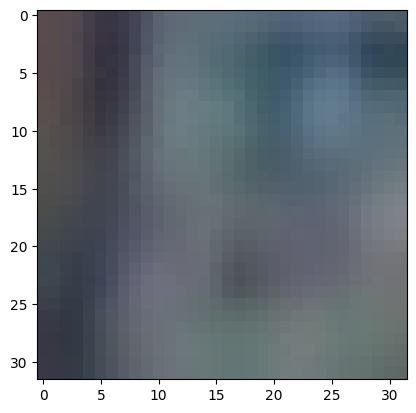

In [184]:
changes = []
skip = np.random.randint(0, 100)
for i in range(len(test_ds)):
    if np.argmax(raw_pred_test[i]) != wunderwafel_ensy_alphahybrid[i]:
        skip -= 1
        if skip == 0:
            raw_x = np.expand_dims(test_ds[i], 0)
            print("\npotential true", np.argmax(raw_pred_test[i]), "changed", wunderwafel_ensy_alphahybrid[i])
            print("raw    \n", raw_pred_test[i])
            print("handled\n", raw_pred_test[i] * final_ova_test_preds[i])
            print("ova\n", final_ova_test_preds[i])
            plt.imshow(test_ds[i])
            break
        
        # print(get_ordinal_pred(raw_pred[i], 0), get_ordinal_pred(raw_pred[i], 1), get_ordinal_pred(raw_pred[i], 2))
        # print(ova[get_ordinal_pred(raw_pred[i], 0)].predict(raw_x, verbose=False))
        # print(ova[get_ordinal_pred(raw_pred[i], 1)].predict(raw_x, verbose=False))
        # print(ova[get_ordinal_pred(raw_pred[i], 2)].predict(raw_x, verbose=False))

In [225]:
import pandas as pd

ensemble_model_name = "ENSY_C2_BETAHYBRID_wunderwafel"
ans = pd.DataFrame({'Id': np.arange(wunderwafel_ensy_alphahybrid.shape[0]), 'Category': wunderwafel_ensy_alphahybrid})
ans.to_csv(f"../answers/{ensemble_model_name}.csv", index=False)